In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from tabulate import tabulate
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from google.colab import files # For downloading files in Colab

In [ ]:
# Step 1: Load your data (assuming 'seeds_sentement.xlsx' is available)
df = pd.read_excel('seeds_sentement.xlsx')
print("Original DataFrame Head:")
print(df.head())

# Assuming your comments are in a column named 'Comment'
comments = df['Comment'].astype(str) # Ensure comments are strings

# Step 2: Create a bag-of-words (BoW) representation
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(comments)

# Create the DataFrame for the BoW representation (Fixes NameError)
bag_of_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Step 3: Compute the distance matrix (Euclidean)
distances = pairwise_distances(X.toarray(), metric='euclidean')

print("\nShape of BoW Matrix:", X.shape)
print("Shape of Distance Matrix:", distances.shape)


Original DataFrame Head:
              Customer Name  Gender  \
0       Natraj B, Bangalore       1   
1  Sandhya Rani, Bangalore        0   
2        Shovan Chakraborty       1   
3               Placeholder      -1   
4              Vinit Ranjan       1   

                                             Comment    Website  \
0                                       good quality  Bigbasket   
1  become black , bad smell , bad quality , old s...  Bigbasket   
2                                               good     Amazon   
3                                               nice     Amazon   
4  good product , nicely packed - even check auth...   Flipkart   

         Seed Type       Date  Label  Sentiment  
0    Pumpkin Seeds 2024-02-12      1          1  
1  Sunflower Seeds 2024-06-11     -1         -1  
2       Flax Seeds 2023-08-10      0          1  
3    Seasame Seeds 2024-06-30      1          1  
4    Pumpkin Seeds 2024-01-29      1          1  

Shape of BoW Matrix: (2981, 2246)
Sh

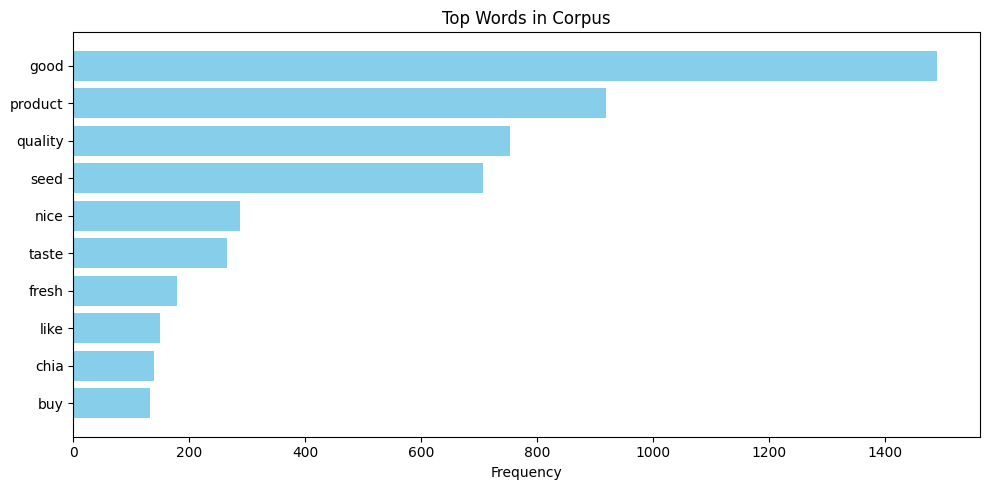

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- Top Words Visualization ---
word_counts = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
top_words = pd.DataFrame({'word': words, 'count': word_counts})
top_words = top_words.sort_values(by='count', ascending=False).head(10)

# Plot top words
filename = 'top_words_bar_chart.png'
plt.figure(figsize=(10, 5))
plt.barh(top_words['word'], top_words['count'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top Words in Corpus')
plt.gca().invert_yaxis() # Invert y-axis to have the highest frequency on top
plt.tight_layout()

# Save and Show
plt.savefig(filename)
plt.show()

# Download
print(f"Downloading {filename}...")
files.download(filename)

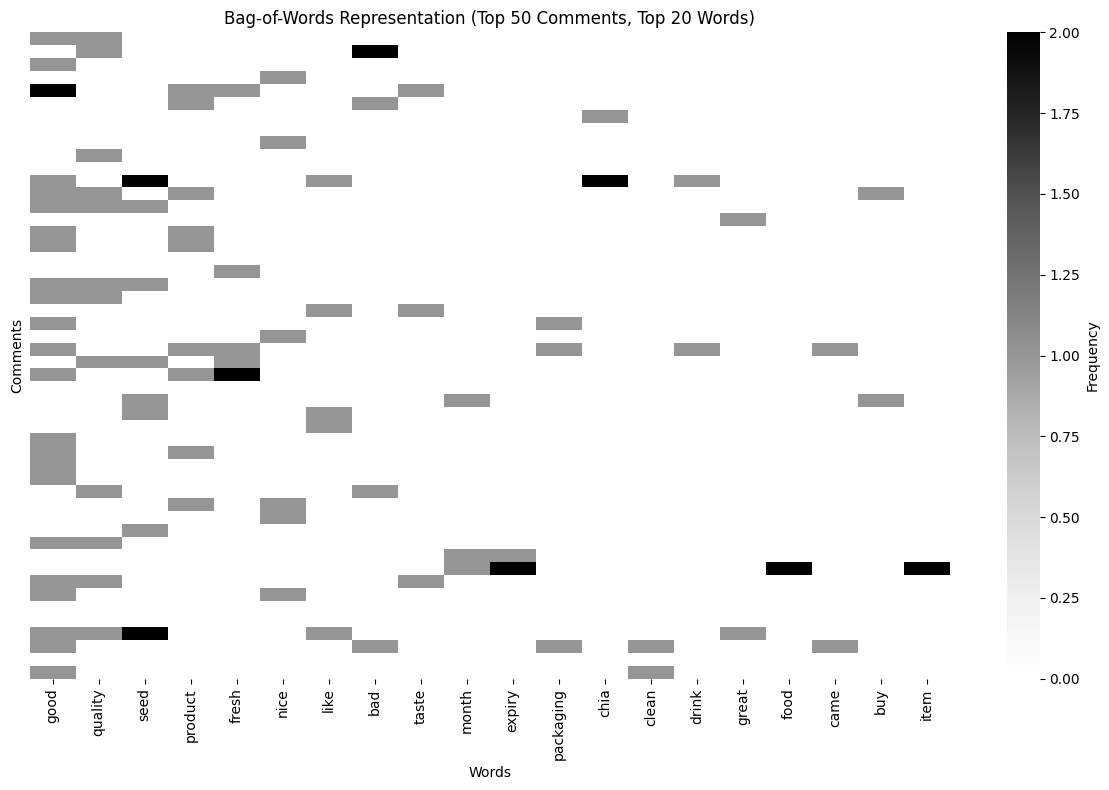

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Limit the BoW DataFrame to the first 50 comments for visualization clarity
limited_bag_of_words_df = bag_of_words_df.head(50)

# Filter to keep only the top 20 words by frequency in this limited set
top_20_words = limited_bag_of_words_df.sum().sort_values(ascending=False).head(20).index
filtered_df = limited_bag_of_words_df[top_20_words]

# Plotting with seaborn heatmap for better visualization
filename = 'bag_of_words_heatmap.png'
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_df, cmap='Greys', cbar_kws={'label': 'Frequency'}, yticklabels=False)
plt.title('Bag-of-Words Representation (Top 50 Comments, Top 20 Words)')
plt.xlabel('Words')
plt.ylabel('Comments')
plt.xticks(rotation=90)
plt.tight_layout()

# Save and Show
plt.savefig(filename)
plt.show()

# Download
print(f"Downloading {filename}...")
files.download(filename)

/usr/local/lib/python3.12/dist-packages/scipy/cluster/hierarchy.py:810: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/tmp/ipython-input-1517434919.py:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(limited_distances, method='ward')


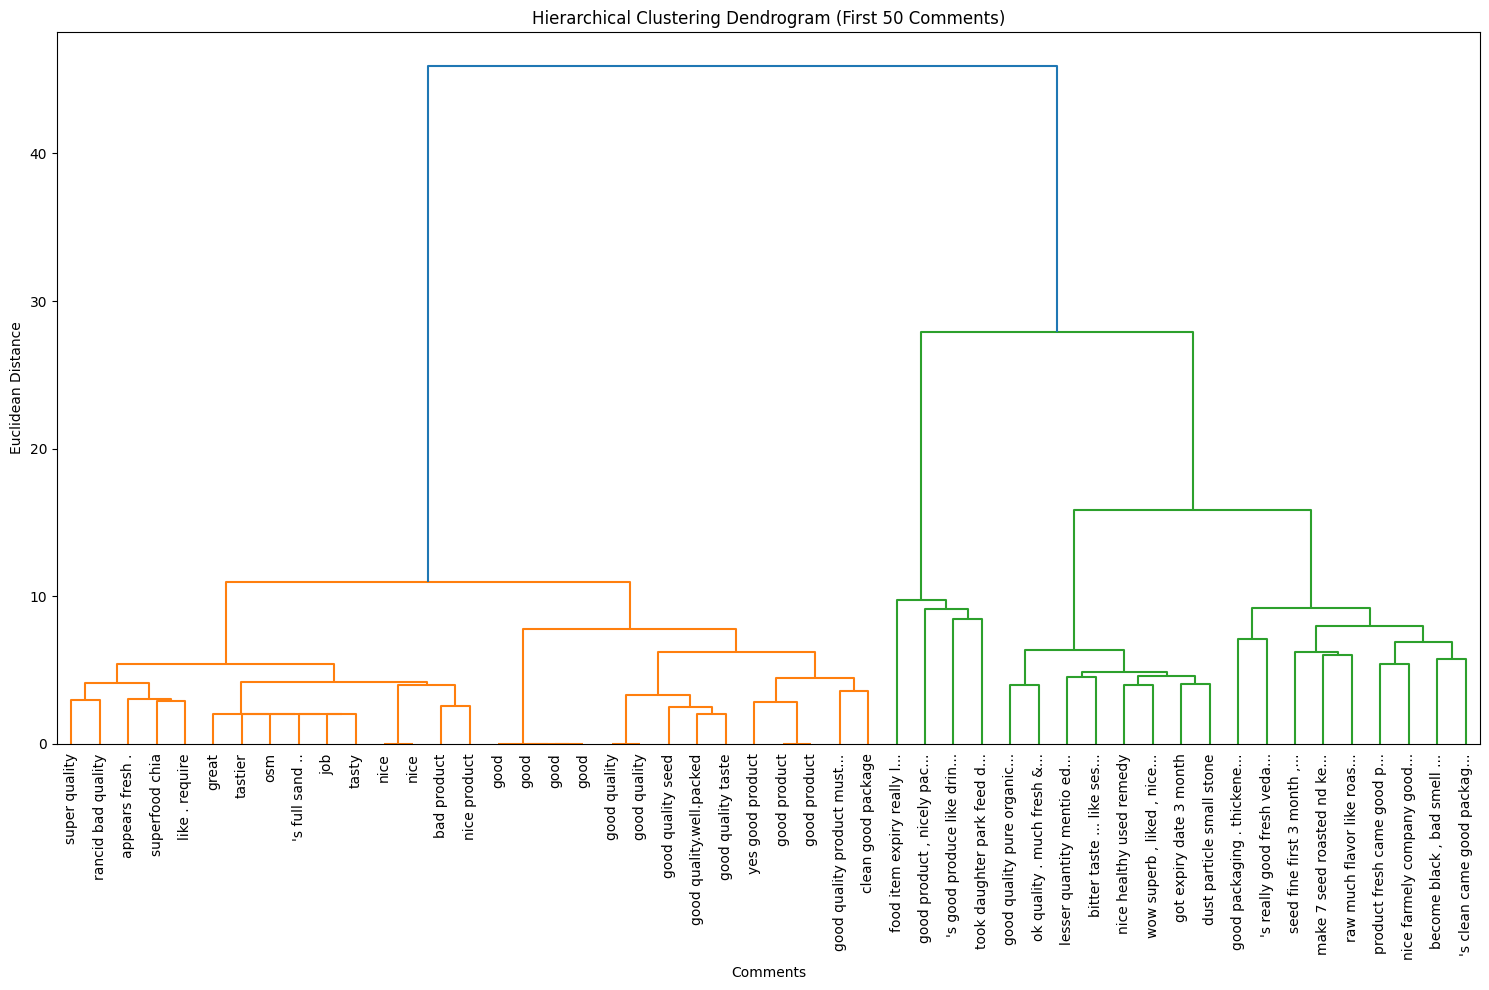

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Limit to the first 50 rows of the distance matrix for a clearer view
limited_distances = distances[:50, :50]
# Create short labels for the first 50 comments
short_comments = [comment[:25] + '...' if len(comment) > 25 else comment for comment in comments[:50]]

# Perform Agglomerative Clustering (needed for linkage matrix generation)
# Note: AgglomerativeClustering (fit) is often just used to calculate distances in this context
agglo_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agglo_model.fit(limited_distances)

# Step 6: Perform Hierarchical Clustering and create Linkage Matrix
# Use 'ward' method on the limited Euclidean distances
linkage_matrix = linkage(limited_distances, method='ward')

# --- Plot Dendrogram ---
filename = 'clustering_dendrogram.png'
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=short_comments, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (First 50 Comments)')
plt.xlabel('Comments')
plt.ylabel('Euclidean Distance')
plt.tight_layout()

# Save and Show
plt.savefig(filename)
plt.show()

# Download
print(f"Downloading {filename}...")
files.download(filename)

In [ ]:
# Define the threshold for cutting the dendrogram
max_d = 5

# Cut the dendrogram to form flat clusters for the limited data
# The linkage matrix from the previous cell is used for both fcluster calls
clusters = fcluster(linkage_matrix, max_d, criterion='distance')

# Limit the DataFrame to the first 50 rows to match the dendrogram subset
df_limited = df.head(50).copy()

# Add the cluster labels to the limited DataFrame
df_limited['cluster'] = clusters

# Prepare the data for tabulate
cluster_data = df_limited[['Comment', 'cluster']].values.tolist()

# Print out the comments with their corresponding cluster labels
print("\nComments with Cluster Labels (Distance Threshold d = 5):")
print(tabulate(cluster_data, headers=['Comment', 'Cluster ID'], tablefmt='grid'))

# --- Save and Download Tabular Output as TXT ---
output_filename_txt = 'comment_clusters_table.txt'
table_string = tabulate(cluster_data, headers=['Comment', 'Cluster ID'], tablefmt='grid')

with open(output_filename_txt, 'w', encoding='utf-8') as f:
    f.write("Comments with Cluster Labels (Distance Threshold d = 5):\n")
    f.write(table_string)

print(f"\nDownloading {output_filename_txt}...")
files.download(output_filename_txt)


Comments with Cluster Labels (Distance Threshold d = 5):
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
| Comment                                                                                                                                                                       |   Cluster ID |
+===============================================================================================================================================================================+==============+
| good quality                                                                                                                                                                  |            4 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the seeds.csv file (assuming it's available)
try:
    df_website = pd.read_csv('seeds.csv')
except FileNotFoundError:
    # Use the original df if seeds.csv is not found
    print("Warning: 'seeds.csv' not found. Using 'seeds_sentement.xlsx' data for sampling.")
    df_website = df.rename(columns={'Comment': 'Comment'}).copy() # Ensure 'Comment' column exists


# Define a function to get 1 positive, 1 negative, and 1 neutral comment per website
def get_comments_by_website(df):
    result_list = []
    # Ensure Sentiment and Website columns exist and are correct
    if 'Sentiment' not in df.columns or 'Website' not in df.columns or 'Comment' not in df.columns:
        print("Error: DataFrame must contain 'Website', 'Sentiment', and 'Comment' columns.")
        return []

    for website in df['Website'].unique():
        # Filter comments by sentiment for each website
        positive = df[(df['Website'] == website) & (df['Sentiment'] == 1)]
        negative = df[(df['Website'] == website) & (df['Sentiment'] == -1)]
        neutral = df[(df['Website'] == website) & (df['Sentiment'] == 0)]

        # Select 1 comment for each sentiment if available and add to the list
        if not positive.empty:
            result_list.append([website, 'Positive', positive.iloc[0]['Comment']])
        if not negative.empty:
            result_list.append([website, 'Negative', negative.iloc[0]['Comment']])
        if not neutral.empty:
            result_list.append([website, 'Neutral', neutral.iloc[0]['Comment']])

    return result_list

# Get the result
result = get_comments_by_website(df_website)

# Print the results in a table format
print("\nSample Comments by Website:")
table_string = tabulate(result, headers=['Website', 'Sentiment', 'Comment'], tablefmt='grid')
print(table_string)

# --- Save and Download Tabular Output as TXT ---
output_filename_txt = 'sample_comments_table.txt'
with open(output_filename_txt, 'w', encoding='utf-8') as f:
    f.write("Sample Comments by Website:\n")
    f.write(table_string)

print(f"\nDownloading {output_filename_txt}...")
files.download(output_filename_txt)


Sample Comments by Website:
+-----------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Website   | Sentiment   | Comment                                                                                                                                                                       |
+===========+=============+===============================================================================================================================================================================+
| Bigbasket | Positive    | good quality                                                                                                                                                                  |
+-----------+-------------+--------------------------------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final sample size for Term Similarity: 20 comments.


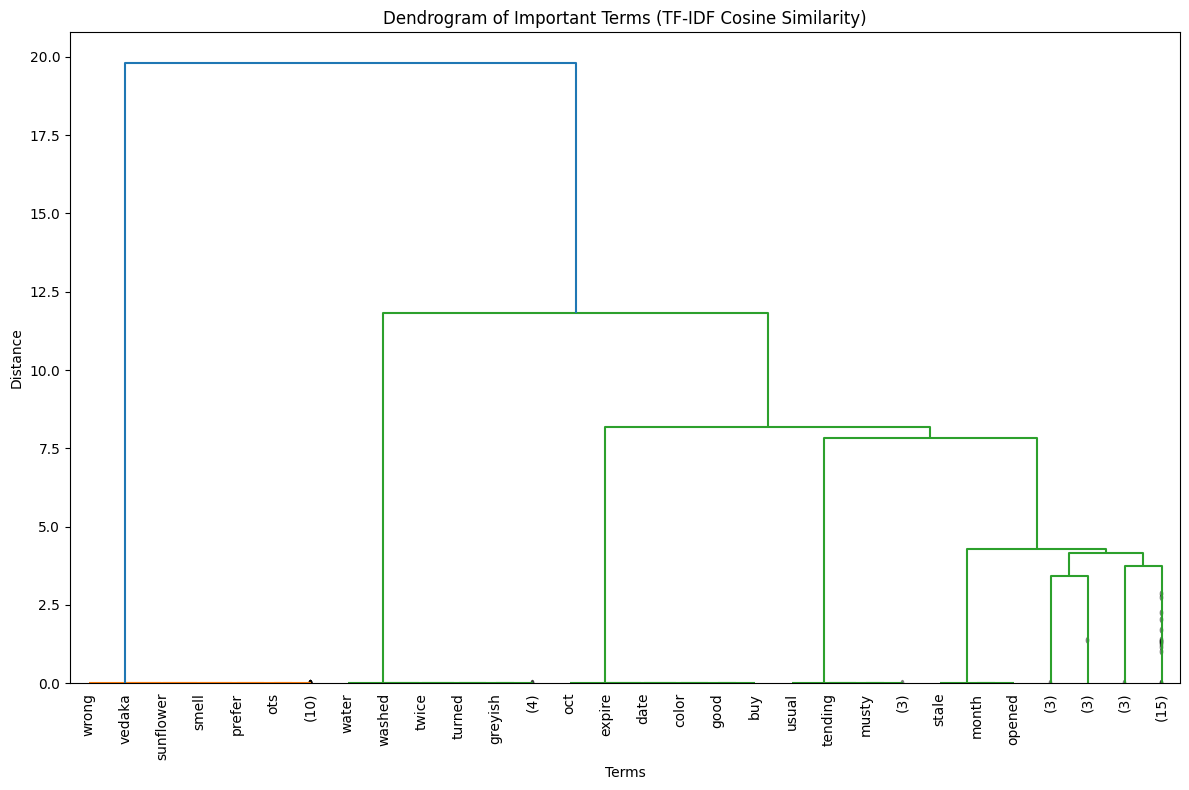

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- Term Similarity Clustering ---

# Define a list of positive words (customizable)
positive_words = ['happy', 'good', 'great', 'awesome', 'positive', 'love', 'excellent', 'fantastic', 'amazing']

# Ensure Comments column is string type
df['Comment'] = df['Comment'].astype(str)

# Find 10 rows with positive words and 10 random rows for the sample
positive_data = df[df['Comment'].str.contains('|'.join(positive_words), case=False, na=False)]
positive_sample = positive_data.sample(n=min(10, len(positive_data)), random_state=42)

random_sample = df.sample(n=10, random_state=42)

# Combine the samples
final_sample = pd.concat([positive_sample, random_sample]).drop_duplicates()
final_sample = final_sample.reset_index(drop=True)

print(f"Final sample size for Term Similarity: {len(final_sample)} comments.")

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the comment data
X = vectorizer.fit_transform(final_sample['Comment'])

# Get feature names (terms)
terms = vectorizer.get_feature_names_out()

# Calculate cosine similarity between terms (transpose X to get term vectors)
similarity = cosine_similarity(X.T)

# Create a linkage matrix for hierarchical clustering
# Note: linkage takes distances, so we use (1 - similarity)
linkage_matrix = linkage(1 - similarity, method='ward')

# Sort terms: positive words first, then alphabetically
sorted_terms = sorted(terms, key=lambda x: (x not in positive_words, x))

# Plot the dendrogram
filename = 'term_similarity_dendrogram.png'
plt.figure(figsize=(12, 8))

dendrogram(
    linkage_matrix,
    labels=sorted_terms,
    truncate_mode='level',
    p=6,
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True,
)

plt.title('Dendrogram of Important Terms (TF-IDF Cosine Similarity)')
plt.xlabel('Terms')
plt.ylabel('Distance')
plt.tight_layout()

# Save and Show
plt.savefig(filename)
plt.show()

# Download
print(f"Downloading {filename}...")
files.download(filename)